# Topic modeling with BERT Mechanisim

* [Topic Modeling with BERT](https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6)

> Leveraging BERT and TF-IDF to create easily interpretable topics.  
> 
> Instead, I decided to come up with a different algorithm that could use BERT and 🤗 transformers embeddings. **The result is BERTopic**, an algorithm for generating topics using state-of-the-art embeddings.
> 
> The main topic of this article will not be the use of BERTopic but a tutorial on how to use BERT to create your own topic model.

In [8]:
!pip install umap-learn hdbscan

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  Using cached umap_learn-0.5.3-py3-none-any.whl
  Using cached numba-0.56.4-cp39-cp39-macosx_11_0_arm64.whl (2.4 MB)
  Using cached pynndescent-0.5.8-py3-none-any.whl
  Using cached tqdm-4.65.0-py3-none-any.whl (77 kB)
  Using cached numpy-1.23.5-cp39-cp39-macosx_11_0_arm64.whl (13.4 MB)
  Using cached llvmlite-0.39.1-cp39-cp39-macosx_11_0_arm64.whl (23.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.2
    Uninstalling numpy-1.24.2:
      Successfully uninstalled numpy-1.24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependenc

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
import umap
import hdbscan

# Data

In [4]:
data = fetch_20newsgroups(subset='all')['data']

# BERT Model

In [6]:
model = SentenceTransformer('distilbert-base-nli-mean-tokens')

# Embeddings

In [7]:
embeddings = model.encode(data, show_progress_bar=True)

Batches:   0%|          | 0/589 [00:00<?, ?it/s]

# Clustering

## Dimensionality Reduction (UMAP)

> we first need to lower the dimensionality of the embeddings as many clustering algorithms handle high dimensionality poorly. UMAP is arguably the best performing as it keeps a significant portion of the high-dimensional local structure in lower dimensionality.

> We reduce the dimensionality to 5 while keeping the size of the local neighborhood at 15. You can play around with these values to optimize for your topic creation. Note that a too low dimensionality results in a loss of information while a too high dimensionality results in poorer clustering results.

In [20]:
umap_embeddings = umap.UMAP(
    n_neighbors=15, 
    n_components=5,
    metric='cosine'
).fit_transform(embeddings)

## Cluster (HDBSCAN)

> Cluster the documents with HDBSCAN. HDBSCAN is a density-based algorithm that works quite well with UMAP since UMAP maintains a lot of local structure even in lower-dimensional space. Moreover, HDBSCAN does not force data points to clusters as it considers them outliers.

In [21]:
cluster = hdbscan.HDBSCAN(
    min_cluster_size=15,
    metric='euclidean',                      
    cluster_selection_method='eom'
).fit(umap_embeddings)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

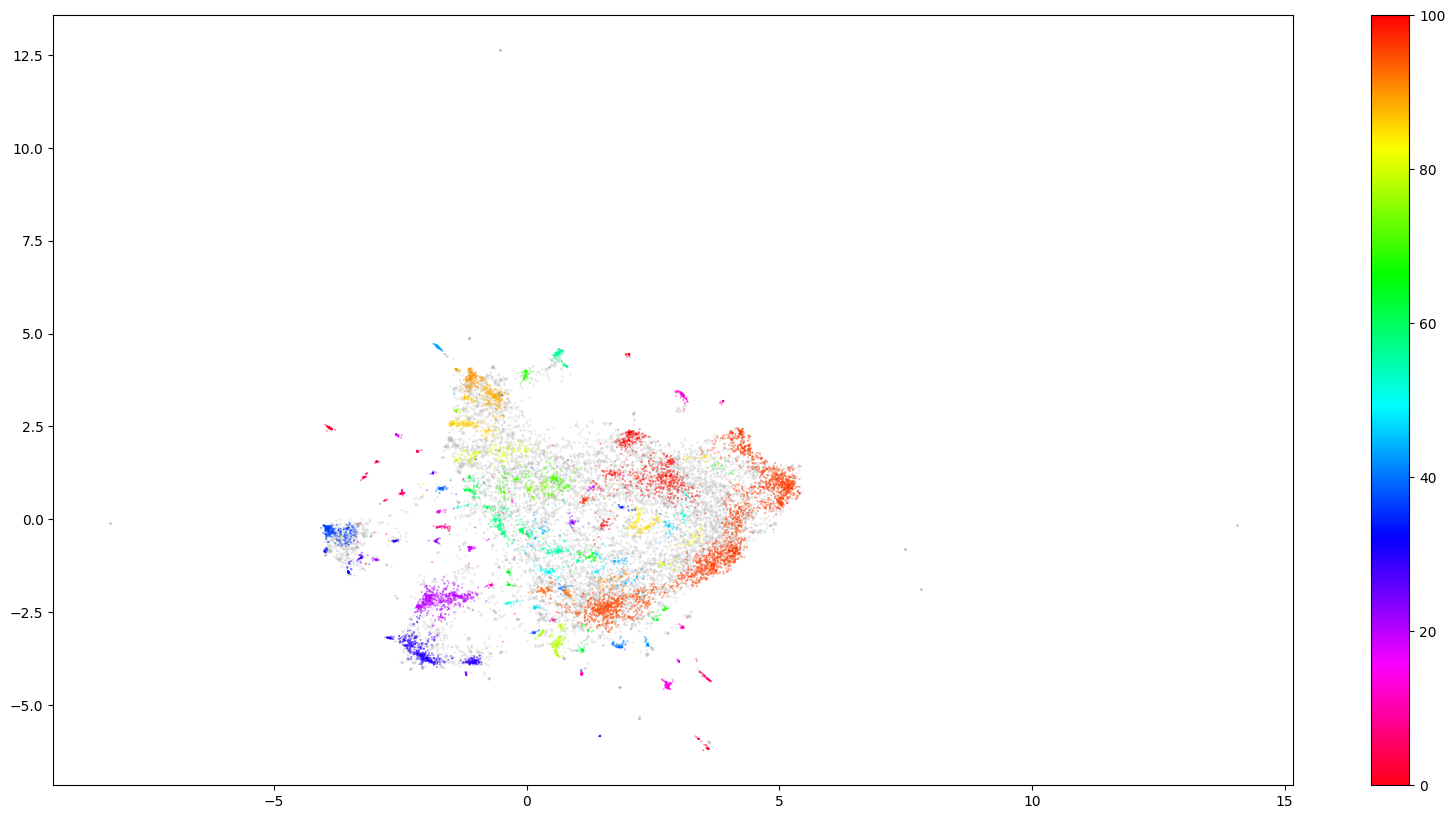

In [22]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

# Topic Creation

Compare importance of words among clusters instead of among documents.

> How can we derive topics from clustered documents? I came up with a class-based variant of TF-IDF (**c-TF-IDF**), that would allow me to extract what makes each set of documents unique compared to the other.  
> 
> The intuition is When you apply TF-IDF as usual on a set of documents, what you are basically doing is **comparing the importance of words between documents**.  
> 
> What if, we instead treat **all documents in a single category (e.g., a cluster) as a single document** and then apply TF-IDF? The result would be a very long document per category and the resulting TF-IDF score would demonstrate the important words in a topic.

First **create a single document for each cluster** of documents.

In [23]:
docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [30]:
docs_per_topic[:5]

,Topic,Doc
0,-1,From: mblawson@midway.ecn.uoknor.edu (Matthew ...
1,0,From: rdb1@cbnewsj.cb.att.com (ronald.j.debloc...
2,1,From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject...
3,2,From: dbd@urartu.sdpa.org (David Davidian)\nSu...
4,3,From: ebosco@us.oracle.com (Eric Bosco)\nSubje...


## c-TF-IDF

The frequency of each word ```t``` is extracted for each class ```i``` and divided by the total number of words ```w```. This action can be seen as a form of regularization of frequent words in the class. Next, the total, unjoined, number of documents ```m``` is divided by the total frequency of word ```t``` across all classes ```n```.

<img src="./image/c-tf-idf.png" align="left" width=400/>

In [24]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

In [25]:
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

In [29]:
tf_idf.shape

(173451, 102)

## Topics

In [27]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
0,-1,9934
97,96,1836
96,95,735
21,20,575
100,99,470
31,30,430
89,88,204
101,100,202
38,37,162
87,86,161
